In [61]:
%matplotlib inline
import numpy as np
import scipy as sp
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Set color map to have light blue background
sns.set()
import statsmodels.formula.api as smf
import statsmodels.api as sm
import patsy
import sklearn
from sklearn import neighbors
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# NFL Betting Strategy - Jeff Dank


## Is there a clear explanation about what this project is about?
This project's goal is see if it's possible to predict the winning team of a football game based upon the betting line odds
The over/under betting line on an NFL game is a value that is set before the game is played. You can thing of this value as
the expected total number of points to be scored by both teams combined. If a bettor places a bet on the "under", then they will
win the bet if the total number of points is below the over / under line. If a bettor places a bet on the "over", then they will
win the bet if the total number of points is above the over / under line. There are many factors that can affect the outcome of an
NFL game's total points scored, but I want to know if there's enough historical data to see trends that can lead to an effective
betting strategy for future games. For instance, if there is an upcoming game between the Miami Dolphins and the Buffalo Bills that 
has an over/under of 40.5 points, is there enough information there to do better than random chance to pick the winner?
Some possible features I'd like to investigate are: the amount of the over / under betting line vs home team winning and
the over / under amount vs individual teams (i.e. Miami Dolphins) winning. 

## Does it state clearly which type of problem (e.g. classification vs. regression)?
There may be some regression analysis done during this project, but the end result will be a calssification result of exactly
which teams to bet on for a given test dataset.


## Does it state the motivation or the goal (or why it’s important) clearly?
The motivation behind this project is to try and be able to make money by betting on NFL games. Perhaps I will stumble upon something
profound and then be able to ditch my day job and live the life of luxury. In order for me to consider this a success, I'd like to 
have by betting strategy be able to do better than random chance. 

## (Bonus) Is the project topic creative? If the author created/defined a problem using publicly available data (the data source has the data only and the problem is not pre-defined like in Kaggle competitions or Kaggle data)
The data was publically available here: http://www.repole.com/sun4cast/data.html#dataprior, but I decided that I wanted to investigate
this for my own interest and possible financial gain

## (Bonus) if the author collected data themselves and defined their problem.
I only downloaded the data from here: http://www.repole.com/sun4cast/data.html#dataprior


## Is data source properly quoted and described? (including links, brief explanations)
Once again... the data can be found here: http://www.repole.com/sun4cast/data.html#dataprior
Dataset Description: All NFL games from 1978 to 2013 have been recorded along with their initial over / under betting lines

## Do they explain the data description properly? The data description can include the data size (number of samples/rows, number of features/columns, byte size if a huge file), data type of each feature (or just a summary if too many features- e.g. 10 categorical, 20 numeric  features), description of features (at least some key features if too many), whether the data is in a multi-table form or gathered from multiple data sources.

The data came in the form of 36 csv files. One csv file for each year from 1978 to 2013. The columns in each CSV file corresponded to:
- **Date:** The date the game was played. Initial datatype is **object**
- **Visitor:** The name of the visiting team. Initial datatype is **object**
- **Visitor Score:** The final score of the visiting team. Initial datatype is **int64**
- **Home Team:** The name of the home team. Initial datatype is **object**
- **Home Score:** The final score of the home team. Initial datatype is **int64**
- **Line:** The betting line showing the home teams spread. i.e. if line is listed as -6 then it is expected the two teams would
score the same amount of points if the home team's final score was reduced by 6. In other words, the home team is favored to win by 6. . Initial datatype is **float64**
- **Total Line:** This is what I've been referring to as the over/under. This is the expected total points scored by both home and visitor team. Initial datatype is **float64**
- **Home Win:** This column was not in the csv files that were downloaded. I created this column for my own benefit to see if the home team won vs the line spread or not. I placed a 1 for a home team win and a 0 for a visitor team win. This column was created during the data compilation process shown in the code below.
- **Over Win:** This column was not in the csv files that were downloaded. I created this column for my own benefit to see if the bet of **over** would win. I placed a 1 if the total score of the home and visitor team were greater than the **Total Line** value. I place a 0 otherwise. 


## (Bonus) If the author has multiple sources of data and joined them together to analyze.
The code below took all of the csv files 1979 to 2013 and placed them into a single csv file for easier processing. The 1978 csv file was ignored because it did not have **Total Line** data in it. Below the code, all_data.csv was read in and the leading rows and all of the columns are displayed for your viewing pleasure. There are **9 columns** and **8206 rows** in the full dataset





In [62]:
# This code takes in all the csv files from years 1979 to 2012 an stores it all in one single file: all_data.csv
# the 2013 year will be used to test my betting strategy
all_data = open('all_data.csv','w')
data_2013 = open('2013_data.csv','w')

all_data.writelines('Date,Visitor,Visitor_Score,Home_Team,Home_Score,Line,Total_Line,Home_Win,Over_Win\n')
data_2013.writelines('Date,Visitor,Visitor_Score,Home_Team,Home_Score,Line,Total_Line,Home_Win,Over_Win\n')
year = 1979
for i in range(35):                                             
    count = 0
    single_year = open('nfl'+str(year)+'lines.csv','r')
    for line in single_year.readlines():
        if count!=0:
            ls = line.split(',')
            if (float(ls[4])-float(ls[5])>float(ls[2])):        # if home score minus(because line is unexpectedly referring to visitor team) the line is greather than the visiting team
                home_win=1
            else:
                home_win=0
            if ((float(ls[4])+float(ls[2]))>float(ls[6])):      # if the home score plus the visitor score is greater than the total line
                over_win=1
            else:
                over_win=0
            if year==2013:
                newline = line.split('\n')[0]+','+str(home_win)+','+str(over_win)+'\n'
                data_2013.writelines(newline)
            else:
                newline = line.split('\n')[0]+','+str(home_win)+','+str(over_win)+'\n'
                all_data.writelines(newline)
                     
        count = count+1
    year = year+1
    single_year.close()
all_data.close()
data_2013.close()


    


In [63]:
all_data = pd.read_csv('all_data.csv')
test_dataset = pd.read_csv('2013_data.csv')
all_data[6500:6550]

,Date,Visitor,Visitor_Score,Home_Team,Home_Score,Line,Total_Line,Home_Win,Over_Win
6500,10/14/2007,Oakland Raiders,14,San Diego Chargers,28,9.5,44.0,1,0
6501,10/14/2007,New Orleans Saints,28,Seattle Seahawks,17,6.5,43.0,0,1
6502,10/15/2007,New York Giants,31,Atlanta Falcons,10,-5.5,44.0,0,0
6503,10/21/2007,Arizona Cardinals,19,Washington Redskins,21,8.0,36.0,0,1
6504,10/21/2007,Atlanta Falcons,16,New Orleans Saints,22,7.5,42.0,0,0
6505,10/21/2007,Baltimore Ravens,14,Buffalo Bills,19,-3.0,33.5,1,0
6506,10/21/2007,Minnesota Vikings,14,Dallas Cowboys,24,9.5,46.5,1,0
6507,10/21/2007,New England Patriots,49,Miami Dolphins,28,-15.5,49.5,0,1
6508,10/21/2007,San Francisco 49ers,15,New York Giants,33,9.5,39.0,1,1
6509,10/21/2007,Tampa Bay Buccaneers,16,Detroit Lions,23,2.5,44.0,1,0


## Data Cleaning
The data was investigated by hand at first. I noticed that in the year 1978 there was no values for the **Total Line** column, so I decided to discard it. Also, I noticed that there was not a column that specifically called out what team won the game. I added the **Home Win** and the **Over Win** columns so that I could easilly see if the home team won vs. the line spread or if the over bet won by a simple binary value. There may come a time when I want to change the datatypes, but I will do that on the fly... perhaps to manipulate a string or make a value categorical and then load it as a float type. 

## Exploratory Data Analysis

After looking at the pairplot for the first time, I realized there was a correlation between a positive line and a home team win. This meant that the home team was **not** favored but won anyway! I decided to take a look at the 2007 season when the New England Patriots went undefeated in the regular season. The lines on their games were negative when they were the visitor. That means in this dataset the line column is referring to the **visitor** team! That is unusual and unexpected. It has been adjusted for in the **Home Win** column above. The pairplot below now reveals the proper and expected correlations.

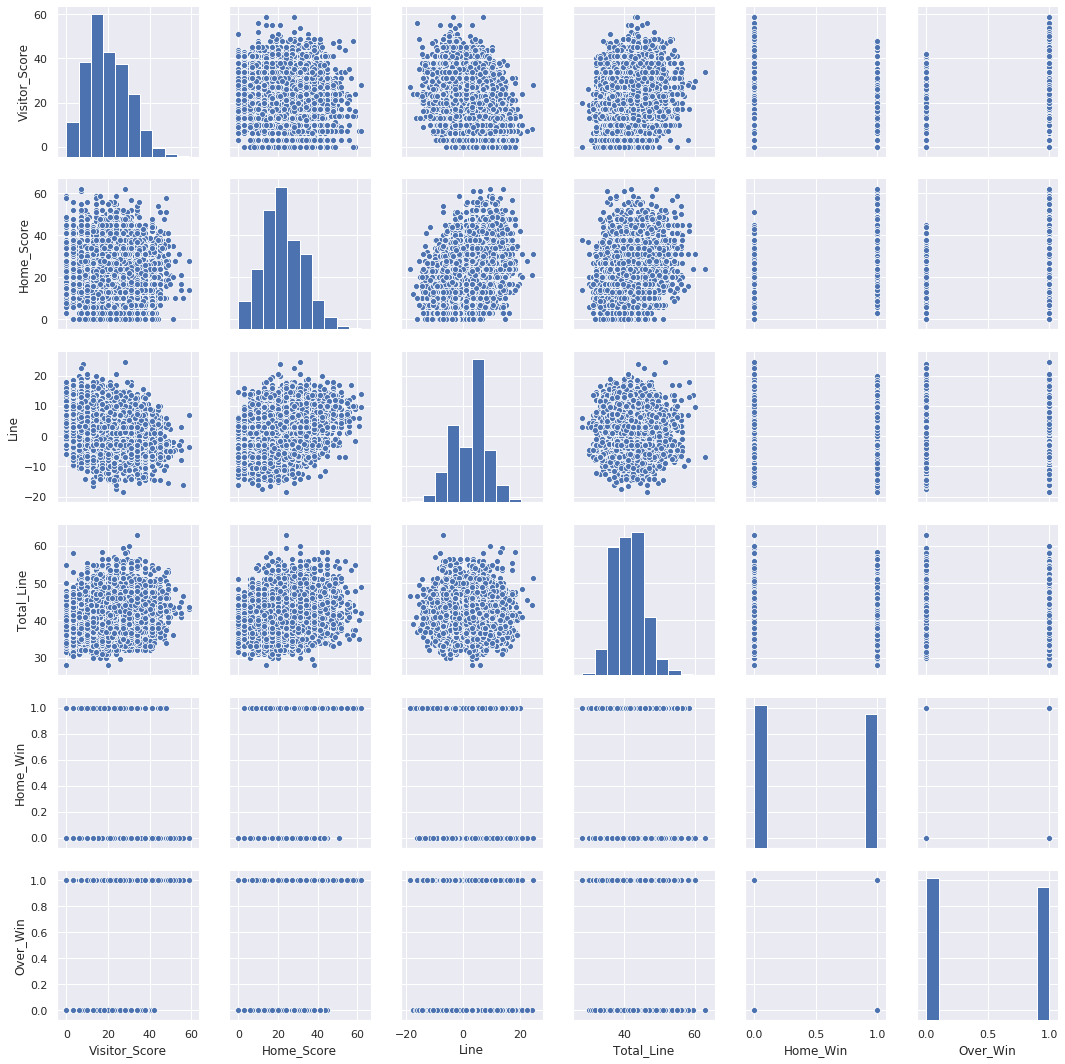

In [64]:
pp = sns.pairplot(all_data)

## Models

Intercept b0 is :  [-0.03243415]
Logistic coefficient b1 is :  [[-0.01281945]]
Score is :  0.5150905432595574


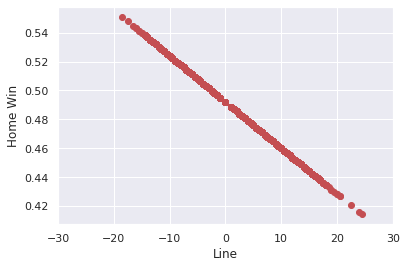

In [96]:
lr = sklearn.linear_model.LogisticRegression(solver='lbfgs')


game_line = all_data.Line
Home_Win=all_data.Home_Win



y,X=patsy.dmatrices("C(Home_Win,[[0],[1]]) ~ 0 + game_line")
default_mod=lr.fit(X,y.ravel())
print('Intercept b0 is : ',default_mod.intercept_)
print('Logistic coefficient b1 is : ',default_mod.coef_)

def logistic(model,x):
    z=np.exp(model.intercept_ + model.coef_ * x)
    return z / (1+z)

game_line_lr = game_line*0
for i in range(len(game_line)):
    game_line_lr[i]=logistic(default_mod,game_line[i])
    
plt.xlim(-30,30); 
plt.xlabel("Line")
plt.ylabel("Home Win")
plt.plot(game_line,game_line_lr,'ro');
#print(default_mod.score(X,y.ravel()))
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
logisticRegr = LogisticRegression(solver='lbfgs')
logisticRegr.fit(x_train, y_train.ravel())
predictions = logisticRegr.predict(x_test)
score = logisticRegr.score(x_test, y_test)
print("Score is : ",score)

In [68]:
test_dataset_line = test_dataset.Line
test_dataset_line.shape
test_dataset_home_win = test_dataset.Home_Win
random_guess = []
modeled_guess = []

random_corrects = 0
modeled_corrects = 0
for i in range(256):
    val = np.random.random()
    if val>0.5:
        random_guess.append(1)
    else:
        random_guess.append(0)
    val_modeled = logistic(default_mod,test_dataset_line[i])
    if val_modeled>0.5:
        modeled_guess.append(1)
    else:
        modeled_guess.append(0)
    if random_guess[i]==test_dataset_home_win[i]:
        random_corrects = random_corrects+1
    if modeled_guess[i]==test_dataset_home_win[i]:
        modeled_corrects = modeled_corrects+1
        
print('The random win percentage was:  ',(random_corrects/256.0)*100.0,'%')
print('The modeled win percentage was: ',(modeled_corrects/256.0)*100.0,'%')

The random win percentage was:   54.296875 %
The modeled win percentage was:  47.265625 %


Intercept b0 is :  [0.50304214]
Logistic coefficient b1 is :  [[-0.01382021]]
Score is :  0.52


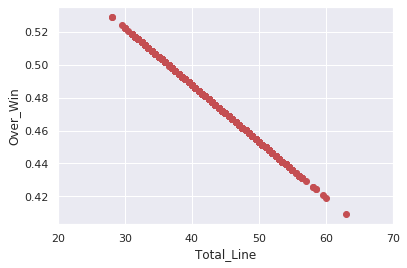

In [98]:
lrTTT = sklearn.linear_model.LogisticRegression(solver='lbfgs')

Over_Win=all_data.Over_Win
TTT_line = all_data.Total_Line



yTTT,XTTT=patsy.dmatrices("C(Over_Win,[[0],[1]]) ~ 0 + TTT_line")
default_modTTT=lr.fit(XTTT,yTTT.ravel())
print('Intercept b0 is : ',default_modTTT.intercept_)
print('Logistic coefficient b1 is : ',default_modTTT.coef_)



TTT_line_lr = TTT_line*0
for i in range(len(TTT_line)):
    TTT_line_lr[i]=logistic(default_modTTT,TTT_line[i])
    
plt.xlim(20,70);  
plt.ylabel("Over_Win")
plt.xlabel("Total_Line")
plt.plot(TTT_line,TTT_line_lr,'ro');
x_trainTTT, x_testTTT, y_trainTTT, y_testTTT = train_test_split(XTTT, yTTT, test_size=0.5, random_state=0)
logisticRegr = LogisticRegression(solver='lbfgs')
logisticRegr.fit(x_trainTTT, y_trainTTT.ravel())
predictions = logisticRegr.predict(x_testTTT)
score = logisticRegr.score(x_testTTT, y_testTTT)
print("Score is : ",score)


In [85]:
test_dataset_TTT = test_dataset.Total_Line
test_dataset_over_win = test_dataset.Over_Win
random_guess_TTT = []
modeled_guess_TTT = []

random_corrects_TTT = 0
modeled_corrects_TTT = 0
for i in range(256):
    val = np.random.random()
    if val>0.5:
        random_guess_TTT.append(1)
    else:
        random_guess_TTT.append(0)
    val_modeled = logistic(default_modTTT,test_dataset_TTT[i])
    if val_modeled>0.5:
        modeled_guess_TTT.append(1)
    else:
        modeled_guess_TTT.append(0)
    if random_guess_TTT[i]==test_dataset_over_win[i]:
        random_corrects_TTT = random_corrects_TTT+1
    if modeled_guess_TTT[i]==test_dataset_over_win[i]:
        modeled_corrects_TTT = modeled_corrects_TTT+1
        
print('The random win percentage was:  ',(random_corrects_TTT/256.0)*100.0,'%')
print('The modeled win percentage was: ',(modeled_corrects_TTT/256.0)*100.0,'%')

The random win percentage was:   44.53125 %
The modeled win percentage was:  49.21875 %


## Results

In both the case of trying to guess the outcome of the game based upon the betting line and the over / under betting line proved unsuccessful. Neither case reached a 50% win rate when tested against the 2013 dataset. At this juncture I would not recommend trying to bet on NFL games using this logistic regression model. 


## Discussion and Conclusion

The hope of having a good betting strategy based only on the initial betting line or the initial over / under line has not panned out as I would have hoped. Although, I knew in the back of my mind, if this had worked as I had hoped, a lot more people would be betting on sports for a living. There are many factors that go into an outcome of an NFL game. Some suggestions for improvements for this study would be to analyze:
- the weather conditions
- the stadium type
- attendance percentage
- month the game was played

After listing thise possible ways to imporve the analysis I decided to take a look just at the Miami Dolphins, since they have been my favorite team for quite a while. The test dataset of 2013 only contained 8 home games for them and I was able to predict a whopping 62.5% correct! However, that was only 5 out of 8 games. I thought that test dataset was too small, so I extended the test dataset into the years 2004 to 20013. This resulted in a sub 50% win rate guess for my model for the Dolphins, but the performance of the models that included all of the teams went up to past 51%. That shows I was able to make an improvement by taking my test dataset from a greater number of years, however, I would not want to try to make a living betting on NFL games using that model. The results of this furhter analysis will be highlighted in the video presentation because it was a bit too cumbersome to try and fit all of the changes into one jupyter notebook. 